In [ ]:
import pandas as pd
from pathlib import Path
from src.data import CENTERS
from src.config import lesion_level_labels_csv, dmtr_csv
from sklearn.linear_model import LogisticRegression

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')
dmtr = pd.read_csv(dmtr_csv).set_index('id')


save_folder = Path('/mnt/c/Users/user/data/results_dl')

results = []
for center in CENTERS:

    # training recalibrator on deep learning predictions made on training set
    dl_training_preds = pd.read_csv(save_folder / center / 'dl_validation_preds.csv').set_index('Unnamed: 0').sum(axis=1)
    dl_training_preds = dl_training_preds.to_frame().join(lesion_fu.patient).rename(columns={0:'training_preds'})
    dl_training_preds = dl_training_preds.groupby('patient').training_preds.min().to_frame().join(dmtr[['response']]).dropna()

    recalibrator = LogisticRegression()
    recalibrator.fit(dl_training_preds[['training_preds']], dl_training_preds.response)

    # recalibrate deep learning predictions on test set
    dl_test_preds = pd.read_csv(save_folder / center / 'dl_preds.csv').set_index('Unnamed: 0').mean(axis=1)
    dl_test_preds = dl_test_preds.to_frame().join(lesion_fu.patient).rename(columns={0:'uncalibrated_dl_preds'})
    dl_test_preds = dl_test_preds.groupby('patient').uncalibrated_dl_preds.min().to_frame()

    dl_test_preds['calibrated_dl_preds'] = recalibrator.predict_proba(dl_test_preds)[:,1]

    # add raw clinical predictions to output file
    clinical_preds = pd.read_csv(save_folder / center / 'clinical_test_preds.csv').set_index('id').rename(columns={'0':'clinical_preds'})
    test_preds = dl_test_preds.join(clinical_preds) 

    # fit clinical + deep learning model on predictions of both models on train set
    clinical_training_preds = pd.read_csv(save_folder / center / 'clinical_training_preds.csv').set_index('id').rename(columns={'0':'clinical_preds'})
    
    results.append(test_preds)

pd.concat(results).to_csv(save_folder / 'predictions.csv')

In [61]:
dl_training_preds

,training_preds,response
patient,,
IM_001,0.618666,1.0
IM_002,0.316599,1.0
IM_004,0.137724,0.0
IM_012,0.423976,0.0
IM_013,0.517145,0.0
...,...,...
UNI_186,0.136427,1.0
UNI_191,0.615664,1.0
UNI_206,0.236350,0.0


In [62]:
clinical_training_preds

,clinical_preds
id,
PREM_AM_001,0.571870
PREM_AM_002,0.593169
PREM_AM_003,0.616024
PREM_AM_005,0.593169
PREM_AM_008,0.571870
...,...
PREM_VU_187,0.602993
PREM_VU_188,0.602993
PREM_VU_189,0.602993


In [9]:
import pandas as pd
from src.config import dmtr_csv

dmtr = pd.read_csv(dmtr_csv).set_index('id')

/tmp/ipykernel_28611/2104799140.py:4: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


In [12]:
one_year_OS = []
for ix, row in dmtr.iterrows():
    label = None
    if pd.isna(row.event_OS) or pd.isna(row.fu_OS):
        label = float('nan')
    elif row.event_OS:
        if int(row.fu_OS.split()[0]) < 365:
            label = 0
        else:
            label = 1
    else:
        if int(row.fu_OS.split()[0]) < 365:
            label = float('nan')
        else:
            label = 1

    one_year_OS.append(label)

dmtr['1yr_OS'] = one_year_OS

one_year_PFS = []
for ix, row in dmtr.iterrows():
    label = None
    if pd.isna(row.event_PFS) or pd.isna(row.fu_PFS):
        label = float('nan')
    elif row.event_PFS:
        if int(row.fu_PFS.split()[0]) < 365:
            label = 0
        else:
            label = 1
    else:
        if int(row.fu_PFS.split()[0]) < 365:
            label = float('nan')
        else:
            label = 1

    one_year_PFS.append(label)

dmtr['1yr_PFS'] = one_year_PFS

In [20]:
lesion_level_labels_csv

'/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv'

In [21]:
from src.config import lesion_level_labels_csv

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('Unnamed: 0')
lesion_fu.merge(dmtr[['1yr_OS','1yr_PFS']], left_on='patient', right_index=True).to_csv(lesion_level_labels_csv, sep=';')

In [25]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline


model = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)),
    ('lr', LogisticRegression())
])

parameter_grid = {
    'lr__C': np.logspace(-4,4,10)
}

grid_search = GridSearchCV(model, parameter_grid, scoring='roc_auc')
grid_search.fit(X, y)

model.set_params(**grid_search.best_params_)


Pipeline(steps=[('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse=False)),
                ('lr', LogisticRegression(C=0.3593813663804626))])

In [40]:
class ClinicalModel:
    def __init__(self):
        self.model = Pipeline([
            ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)),
            ('lr', LogisticRegression())
        ])
        self.grid_search = GridSearchCV(
            self.model,
            {'lr__C': np.logspace(-4,4,10)},
            scoring='roc_auc',
            n_jobs=1
        )

    def fit(self, X, y):
        self.grid_search.fit(X, y)
        self.model.set_params(**self.grid_search.best_params_)
        self.model.fit(X, y)
        self.classes_ = self.model.classes_

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, *args, **kwargs):
        return {}

    def set_params(self, *args, **kwargs):
        return self

model = ClinicalModel()

cross_val_score(model, X, y, method='predict_proba', n_jobs=1)

gridding
finished
gridding
finished
gridding
finished
gridding
finished
gridding
finished


array([[0.47101648, 0.52898352],
       [0.4778448 , 0.5221552 ],
       [0.48096056, 0.51903944],
       ...,
       [0.40517964, 0.59482036],
       [0.43137263, 0.56862737],
       [0.43137263, 0.56862737]])

In [31]:
import pandas as pd
from pathlib import Path

r = Path('/mnt/c/Users/user/data/results_dl')
df = pd.concat([
    pd.read_csv(f / 'dl_preds.csv') for f in r.iterdir()
]).set_index('Unnamed: 0')

df['dl_pred'] = df.mean(axis=1)

lesion_level_labels_csv = "/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv"
dmtr_csv = "/mnt/c/Users/user/data/tables/dmtr.csv"

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')
dmtr = pd.read_csv(dmtr_csv).set_index('id')

df = df.merge(lesion_fu[['patient']], left_index=True, right_index=True)
df = df.groupby('patient').dl_pred.min().to_frame()
df = df.merge(dmtr[['response','center']], left_index=True, right_index=True).dropna()

/tmp/ipykernel_24656/1037937539.py:15: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


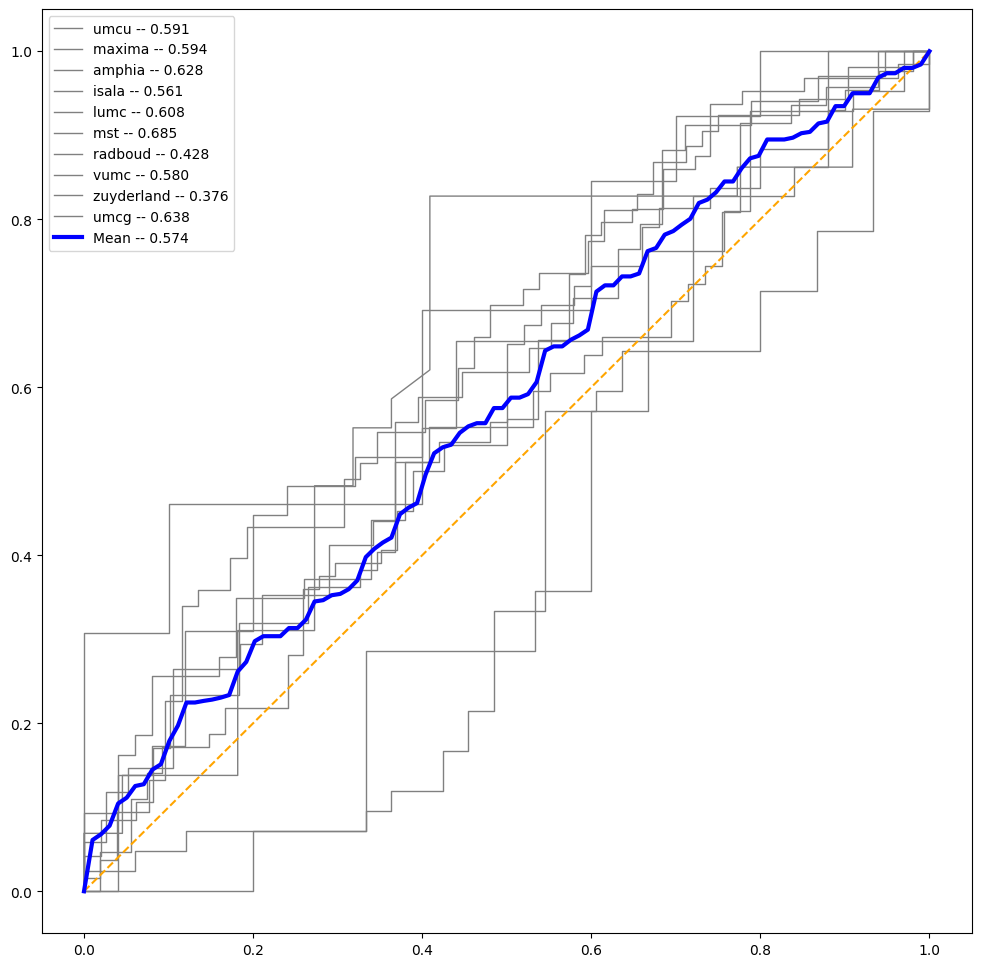

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import numpy as np

tprs = []
aucs = []
n = []
mean_fpr = np.linspace(0,1,100)

plt.figure(figsize=(12,12))
for center in df.center.unique():
    subset = df[df.center == center]
    auc = roc_auc_score(subset.response, subset.dl_pred)
    aucs.append(auc)
    fpr, tpr, _ = roc_curve(subset.response, subset.dl_pred)
    plt.plot(fpr, tpr, c='gray', lw=1, label=f'{center} -- {auc:.3f}')

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(interp_tpr)

    n.append(len(subset))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0
mean_tpr[-1] = 1


plt.plot([0,1],[0,1], linestyle='--', c='orange')

plt.plot(mean_fpr, mean_tpr, c='b', lw=3, label=f'Mean -- {np.average(aucs, weights=n):.3f}')
plt.legend()
plt.show()

In [30]:
from src.data import CENTERS
from pathlib import Path
from src.config import dmtr_csv, lesion_level_labels_csv
import pandas as pd

r = Path('/mnt/c/Users/user/data/results_dl')

df = pd.concat([pd.read_csv(r / c / 'dl_preds.csv') for c in CENTERS]).set_index('Unnamed: 0')
mean_pred = df.mean(axis=1)
std = df.std(axis=1)
df['mean_pred'] = mean_pred
df['std_pred'] = std


dmtr = pd.read_csv(dmtr_csv).set_index('id')
lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')

df = df.join(lesion_fu[['lesion_response', 'patient','center']]).dropna()

df = df.reset_index().rename(columns={'Unnamed: 0':'lesion'})


/tmp/ipykernel_571/2479781040.py:15: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


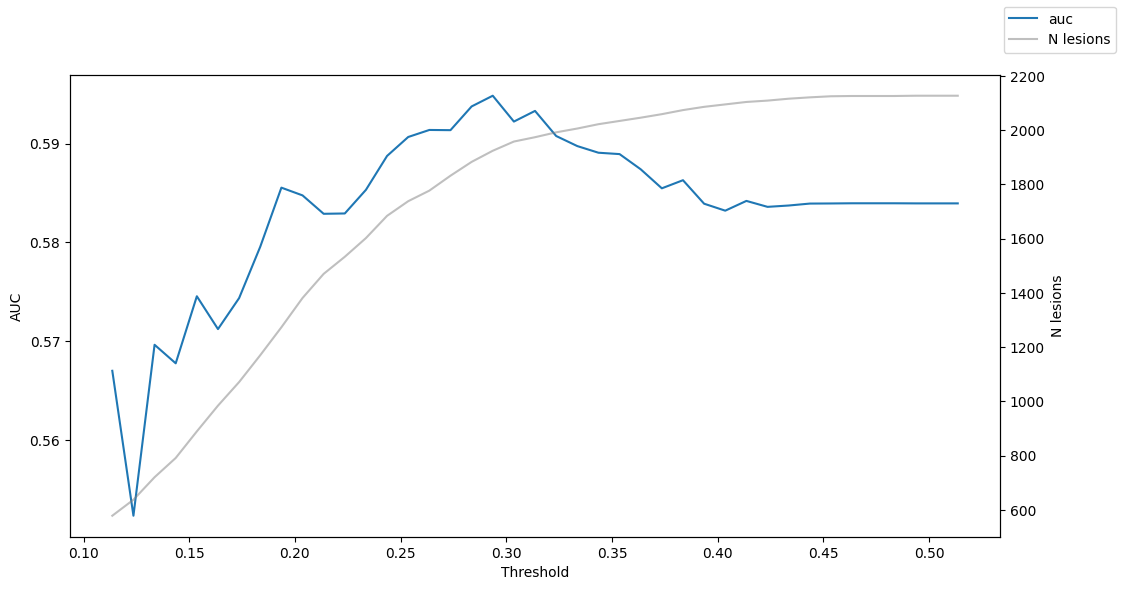

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

thresholds = np.arange(df.std_pred.min(), df.std_pred.max(), step=0.01)[10:]

auc, n = [], []
for threshold in thresholds:
    subset = df[df.std_pred < threshold]
    n.append(len(subset))
    
    center_aucs = []
    center_sizes = []
    for center in subset.center.unique():
        center_subset = subset[subset.center == center]
        center_aucs.append(
            roc_auc_score(center_subset.lesion_response, center_subset.mean_pred)
        )
        center_sizes.append(len(center_subset))
    auc.append(np.average(center_aucs, weights=center_sizes))

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(thresholds, auc, label='auc')
ax.set_xlabel('Threshold')
ax.set_ylabel('AUC')

ax2 = ax.twinx()
ax2.plot(thresholds, n, label='N lesions', c='gray', alpha=0.5)
ax2.set_ylabel('N lesions')

fig.legend()
fig.show()


In [33]:
minima = df.groupby('patient')['mean_pred'].min()

determining_lesions = []
for ix, row in df.iterrows():
    patient = row['patient']
    minimum = minima.loc[patient]
    if row['mean_pred'] == minimum:
        determining_lesions.append(row['lesion'])

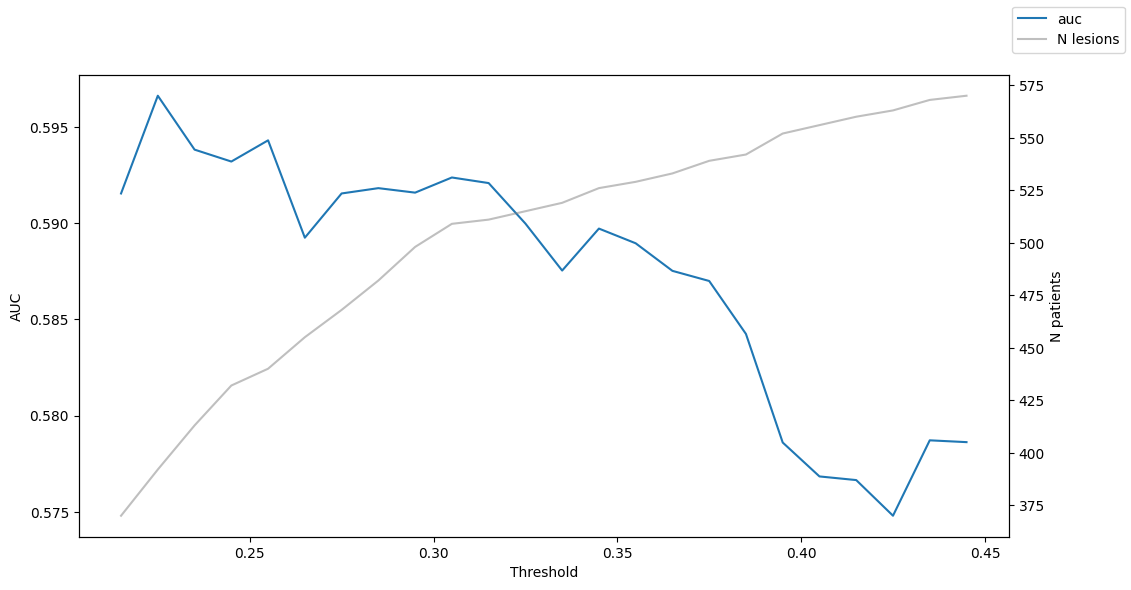

In [34]:
minimum_only = df[df.lesion.isin(determining_lesions)].set_index('patient')
minimum_only = minimum_only.join(dmtr['response']).dropna(subset=['response'])

thresholds = np.arange(minimum_only.std_pred.min(), minimum_only.std_pred.max(), step=0.01)[20:]

auc, n = [], []
for threshold in thresholds:
    subset = minimum_only[minimum_only.std_pred < threshold]
    n.append(len(subset))
    center_aucs = []
    center_sizes = []
    for center in subset.center.unique():
        center_subset = subset[subset.center == center]
        center_aucs.append(
            roc_auc_score(center_subset.response, center_subset.mean_pred)
        )
        center_sizes.append(len(center_subset))
    auc.append(np.average(center_aucs, weights=center_sizes))

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(thresholds, auc, label='auc')
ax.set_xlabel('Threshold')
ax.set_ylabel('AUC')

ax2 = ax.twinx()
ax2.plot(thresholds, n, label='N lesions', c='gray', alpha=0.5)
ax2.set_ylabel('N patients')

fig.legend()
fig.show()

In [36]:
from src.eval import TrainedModel, Config, get_fold_vs_run_ids
from src.data import DataModule
from src.config import radiomics_folder, lesion_level_labels_csv
import torch.nn as nn
from pathlib import Path


sweep_id = '1gg58uu2'
fold_vs_id = get_fold_vs_run_ids(sweep_id)

test_center = 'umcg'
fold = 0

run_id = fold_vs_id[test_center][fold]
model = TrainedModel(run_id, '/dev/zero', fold)

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    
model.model.last_linear = Identity()
model.model.eval()

mock_wandb_config = Config(
    roi_selection_method='crop',
    dim = 3,
    size=182,
    roi_size=142,
    test_center=test_center,
    max_batch_size=6,
    inner_fold=0,
    lesion_target='lesion_response',
    sampler='vanilla',
    augmentation_noise_std=0.001
)

dm = DataModule(radiomics_folder, lesion_level_labels_csv, mock_wandb_config)
dm.setup(stage='test')
dl = dm.test_dataloader()

/home/rens/repos/premium_dl_ct/src/eval.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.predictions = pd.Series(name=f'fold_{fold}')
Loading dataset: 100%|██████████| 420/420 [00:00<00:00, 974340.53it/s]


In [37]:
import pandas as pd

model.model.cuda()

df = pd.DataFrame(columns=[f'feature{f}' for f in range(2048)])

for batch in dl:
    x = batch['img'].cuda()

    y_hat = model.model(x).cpu().detach().numpy()

    for ix, name in enumerate([Path(p).name for p in batch['img_meta_dict']['filename_or_obj']]):
        df.loc[name] = y_hat[ix].tolist()


/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tab:orange
tab:blue


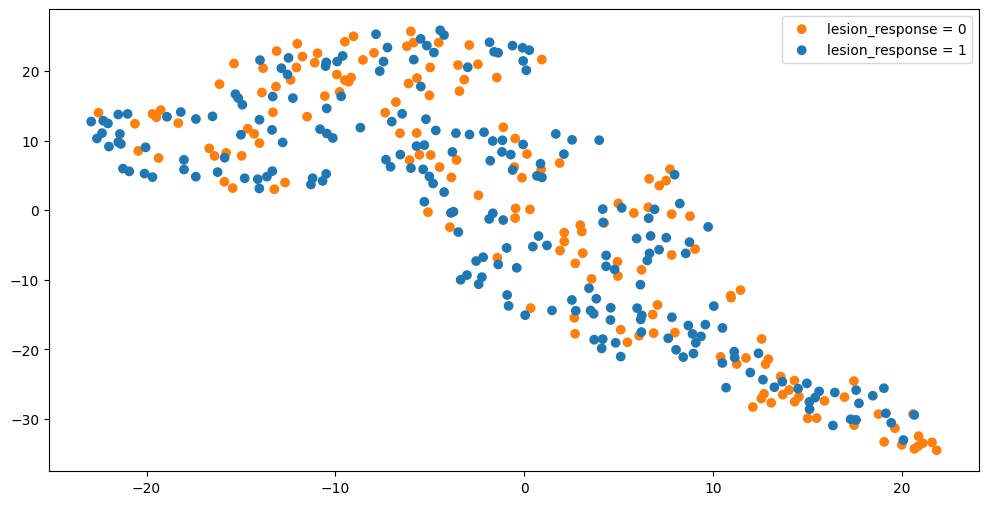

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')

df = df.join(lesion_fu[['organ','lesion_response']])
feature_columns = [f'feature{f}' for f in range(2048)]

tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(df[feature_columns])

groupby = 'lesion_response'
colors = {
    0:'tab:orange',
    1:'tab:blue'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


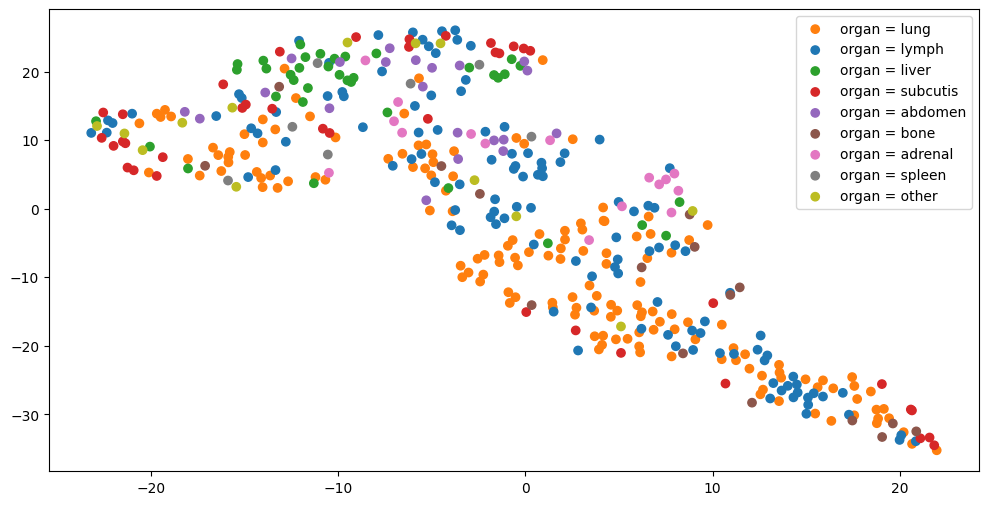

In [39]:
groupby = 'organ'
colors = {
    'lung':'tab:orange',
    'lymph':'tab:blue',
    'liver':'tab:green',
    'subcutis':'tab:red',
    'abdomen':'tab:purple',
    'bone':'tab:brown',
    'adrenal':'tab:pink',
    'spleen':'tab:grey',
    'other':'tab:olive'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

In [17]:
len(y_hat[0].tolist())

2048

In [36]:
import numpy as np
from monai.data import Dataset
from monai.transforms import (
    Compose, 
    LoadImaged, 
    EnsureChannelFirstd, 
    RandRotated, 
    CenterSpatialCropd,
    RandGaussianNoised,
    SaveImaged
)
from torch.utils.data import DataLoader

data = dm.train_data

t = Compose([
    LoadImaged(keys=['img']),
    EnsureChannelFirstd(keys=['img']),
    RandRotated(
        keys=['img'], 
        range_x=(0,2*np.pi), 
        range_y = (0,2*np.pi), 
        range_z=(0,2*np.pi), 
        prob=1
    ),
    CenterSpatialCropd(keys=['img'], roi_size=(128,128,128)),
    RandGaussianNoised(keys=['img'], prob=1, std=0.001),
    # SaveImaged(
    #     keys=['img'], 
    #     output_dir='/mnt/c/Users/user/data/dl_radiomics/augmented', 
    #     output_ext='.nii.gz',
    #     resample=False,
    #     separate_folder=False,
    # )
])

ds = Dataset(data, t)
dl = DataLoader(ds, batch_size=6)

x = next(iter(dl))

In [37]:
x['img'].shape

(6, 1, 128, 128, 128)

In [25]:
import pandas as pd

df = pd.read_csv("/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv", sep=';')

In [29]:
len(df)

2772

In [8]:
import pandas as pd

df = pd.read_csv('/mnt/c/Users/user/Downloads/wandb_export_2023-01-20T08_15_03.480+01_00.csv')
df = df[df.State == 'finished']

In [9]:
df.columns

Index(['Name', 'Agent', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime',
       'Sweep', 'T_0', 'aggregation_function', 'dim', 'dropout',
       'learning_rate_max', 'lesion_target', 'lr_min', 'max_batch_size',
       'max_epochs', 'model', 'n_forward_per_backwards', 'optimizer',
       'patience', 'patient_target', 'pretrained', 'roi_selection_method',
       'roi_size', 'sampler', 'seed', 'size', 'weight_decay', 'epoch', 'lr',
       'train_auc', 'train_loss', 'train_patient_auc', 'trainer/global_step',
       'valid_auc', 'valid_loss', 'valid_patient_auc'],
      dtype='object')

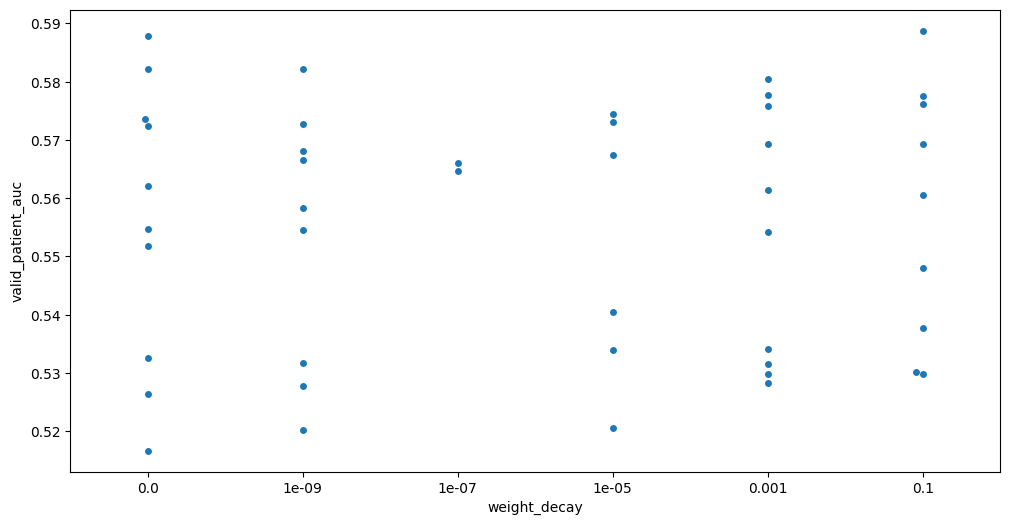

In [10]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(12,6))
sn.swarmplot(data=df, x='weight_decay', y='valid_patient_auc')
plt.show()

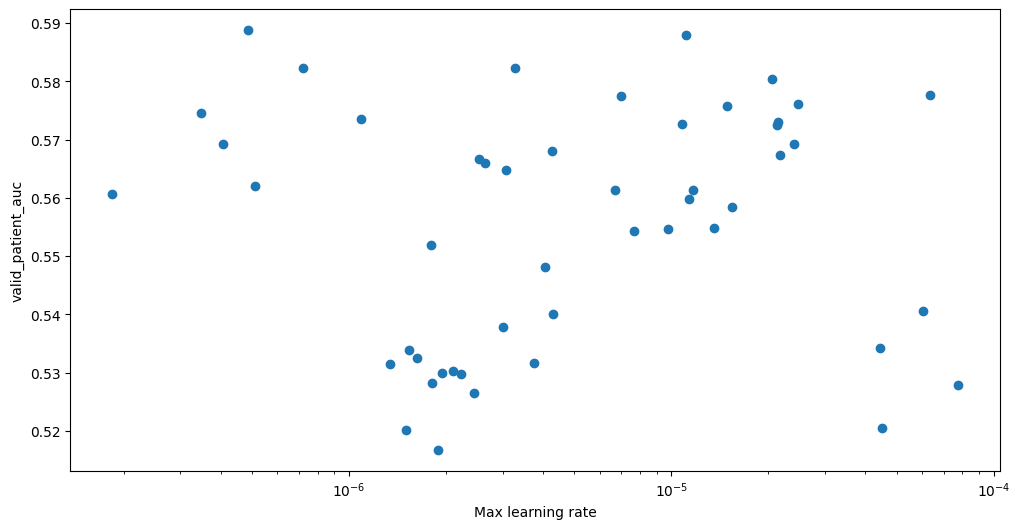

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(df.lr, df.valid_patient_auc)
plt.xlabel('Max learning rate')
plt.ylabel('valid_patient_auc')
plt.xscale('log')
plt.show()

In [48]:
batch = np.array(list(range(32)))


mini_batch_size =32
for ix in range(0, len(batch), mini_batch_size):
    print(batch[ix:ix+mini_batch_size])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [50]:
len(x)

32

In [23]:
new_grad[0,0,0]

array([-9.4738527e-05, -1.0190648e-04, -1.3707948e-04, -1.4512578e-04,
       -1.3249271e-04, -5.2837066e-05, -3.5660356e-05], dtype=float32)

In [24]:
original_grad[0,0,0]

array([-9.4678675e-05, -1.0183325e-04, -1.3698640e-04, -1.4505384e-04,
       -1.3245209e-04, -5.2787924e-05, -3.5580433e-05], dtype=float32)

In [21]:
y_hat.detach().numpy()

array([[0.34611627],
       [0.34112442],
       [0.40652257],
       [0.39151615],
       [0.3430734 ],
       [0.3531861 ]], dtype=float32)

In [22]:
y_hat2.detach().numpy()

array([[0.34611627],
       [0.34112436],
       [0.4065227 ],
       [0.39151615],
       [0.34307343],
       [0.35318622]], dtype=float32)

In [35]:
from pathlib import Path
import numpy as np

dl = dm.val_dataloader()

batches = []
for batch in dl:
    batches.append(np.stack([
        batch['label'].numpy(),
        batch['organ'],
        [Path(f).name for f in batch['img_meta_dict']['filename_or_obj']]
    ], axis=1))

Loading dataset: 100%|██████████| 576/576 [00:00<00:00, 550072.66it/s]


In [32]:
possible = [case['img'].split('/')[-1] for case in dm.train_data]

In [20]:
batch['organ']

['adrenal',
 'bone',
 'liver',
 'liver',
 'liver',
 'lung',
 'lung',
 'lung',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'other',
 'abdomen',
 'abdomen',
 'bone',
 'liver',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'other',
 'subcutis',
 'subcutis']

In [5]:
from src.config import lesion_level_labels_csv, dmtr_csv
import pandas as pd

dmtr = pd.read_csv(dmtr_csv)
lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';')

/tmp/ipykernel_19073/2195945971.py:4: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv)


In [11]:
import numpy as np

np.unique([pt for pt in lesion_fu.patient if not pt in dmtr.id.values])

array(['UMCG_118', 'UMCG_382', 'UMCG_400', 'UMCG_448', 'UMCG_457',
       'UMCG_469', 'UMCG_548', 'UMCG_650'], dtype='<U8')

In [12]:
umcg = pd.read_excel('/mnt/c/Users/user/repos/PREMIUM/code/radiomics_paper/data/raw_dmtr/umcg.xlsx')

In [24]:
umcg[umcg.upn == 'UMCG_656'].ptloc

26385    1.0
26386    1.0
26387    1.0
26388    1.0
26389    1.0
        ... 
26836    1.0
26837    1.0
26838    1.0
26839    1.0
26840    1.0
Name: ptloc, Length: 456, dtype: float64

In [53]:
import pandas as pd

df = pd.read_csv("/mnt/d/premium_data/umcg/umcg_followup (1).csv", sep=';')

In [55]:
df['delta1'] = df['fu1'] / df['baseline']
df['delta2'] = df['fu2'] / df['baseline']
df['delta3'] = df['fu3'] / df['baseline']

In [63]:
last_fus = []
for _, lesion in df.iterrows():
    last_fu = float('nan')
    if not pd.isna(lesion.delta1):
        last_fu = lesion.delta1
    if not pd.isna(lesion.delta2):
        last_fu = lesion.delta2
    if not pd.isna(lesion.delta3):
        last_fu = lesion.delta3
    last_fus.append(last_fu)

df['last_fu'] = last_fus

In [67]:
lesion_response, lesion_benefit = [],[]
for _, lesion in df.iterrows():
    if pd.isna(lesion.last_fu):
        lesion_response.append(float('nan'))
        lesion_benefit.append(float('nan'))
        continue

    if lesion.last_fu < 0.7:
        lesion_response.append(1)
    else: 
        lesion_response.append(0)

    if lesion.last_fu < 1.2:
        lesion_benefit.append(1)
    else: 
        lesion_benefit.append(0)

df['lesion_response'] = lesion_response
df['lesion_benefit'] = lesion_benefit

In [68]:
df

,lesion,name,patient,start_date,scan_date,baseline,fu1,fu2,fu3,delta1,delta2,delta3,last_fu,lesion_response,lesion_benefit
0,UMCG_004abdomen_0.nii.gz,softtissue1,UMCG_004,17-10-2016,30-9-2016,97.0,85.0,NaN,NaN,0.876289,NaN,NaN,0.876289,0.0,1.0
1,UMCG_004abdomen_1.nii.gz,lymph1,UMCG_004,17-10-2016,30-9-2016,20.0,16.0,NaN,NaN,0.800000,NaN,NaN,0.800000,0.0,1.0
2,UMCG_004abdomen_2.nii.gz,lymph2,UMCG_004,17-10-2016,30-9-2016,27.0,49.0,NaN,NaN,1.814815,NaN,NaN,1.814815,0.0,0.0
3,UMCG_004thorax_0.nii.gz,lung1,UMCG_004,17-10-2016,30-9-2016,29.0,32.0,NaN,NaN,1.103448,NaN,NaN,1.103448,0.0,1.0
4,UMCG_004thorax_1.nii.gz,lymph1,UMCG_004,17-10-2016,30-9-2016,44.0,11.0,NaN,NaN,0.250000,NaN,NaN,0.250000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,UMCG_738abdomen_0.nii.gz,subcutis1,UMCG_738,11-4-2017,15-3-2017,10.0,13.0,12.0,9.0,1.300000,1.200000,0.900,0.900000,0.0,1.0
459,UMCG_738abdomen_1.nii.gz,lymph1,UMCG_738,11-4-2017,15-3-2017,21.0,21.0,0.0,NaN,1.000000,0.000000,NaN,0.000000,1.0,1.0
460,UMCG_738abdomen_2.nii.gz,lymph2,UMCG_738,11-4-2017,15-3-2017,19.0,18.0,0.0,NaN,0.947368,0.000000,NaN,0.000000,1.0,1.0
461,UMCG_738abdomen_3.nii.gz,subcutis2,UMCG_738,11-4-2017,15-3-2017,8.0,7.0,6.0,5.0,0.875000,0.750000,0.625,0.625000,1.0,1.0


In [69]:
organ_synonyms = {
    'lung':['lung','pleur','pulm'],
    'liver':['liver'],
    'lymph':['lymph', 'lymoh', 'inguin', 'supraclav'],
    'subcutis':['subcut'],
    'adrenal':['adren'],
    'abdomen':['abd', 'mesent', 'intest', 'perit','mesent','adbom'],
    'bone':['bone', 'os', 'th5', 'ileum'],
    'spleen':['spleen']
}

organs = []
for name in df['name'].tolist():
    name = name.lower()

    found = False
    for organ, synonyms in organ_synonyms.items():
        if any([synonym in name for synonym in synonyms]):
            organs.append(organ)
            found = True
            break

    if not found:
        organs.append('other')
        
df['organ'] = organs

In [71]:
df.to_csv('/mnt/d/premium_data/umcg/lesion_followup_curated.csv')

In [38]:
df.drop(columns=['Unnamed: 0']).to_csv("/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv")

In [24]:
val_dl = dm.val_dataloader()

val_batches = []
for batch in val_dl:
    val_batches.append(
        list(zip(batch['patient'], batch['label'].numpy().tolist()))
    )

Loading dataset: 100%|██████████| 568/568 [00:00<00:00, 596485.90it/s]


In [43]:
from collections import defaultdict

def count_per_patient(batches):
    count = defaultdict(int)
    for batch in batches:
        for case in batch:
            count[case[0]] += 1

    assert max(list(count.values())) <= 5

def no_overlap(train, val):
    train_patients = set()
    for batch in train:
        for case in batch:
            train_patients.add(case[0])

    val_patients = set()
    for batch in val:
        for case in batch:
            val_patients.add(case[0])

    assert train_patients.isdisjoint(val_patients)

count_per_patient(batches)
no_overlap(batches, val_batches)

In [3]:
from src.config import radiomics_folder, lesion_level_labels_csv
import pandas as pd

fu = pd.read_csv(lesion_level_labels_csv, sep=';')

In [4]:
import os

radiomics = pd.read_csv('/mnt/c/Users/user/data/tables/radiomics_v2.csv').set_index('Unnamed: 0')

In [5]:
df = radiomics.join(fu.set_index('lesion'))

In [6]:
from sklearn.preprocessing import StandardScaler

df[radiomics.columns] = StandardScaler().fit_transform(df[radiomics.columns])

In [10]:
df.lesion_response == 1

Unnamed: 0
IM_047_0.nii.gz          True
IM_047_1.nii.gz          True
IM_048_0.nii.gz          True
IM_048_1.nii.gz          True
IM_048_2.nii.gz         False
                        ...  
PREM_RA_113_0.nii.gz    False
PREM_RA_113_1.nii.gz    False
PREM_RA_113_2.nii.gz    False
PREM_RA_113_3.nii.gz    False
PREM_RA_156_0.nii.gz    False
Name: lesion_response, Length: 2351, dtype: bool

/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tab:orange
tab:blue


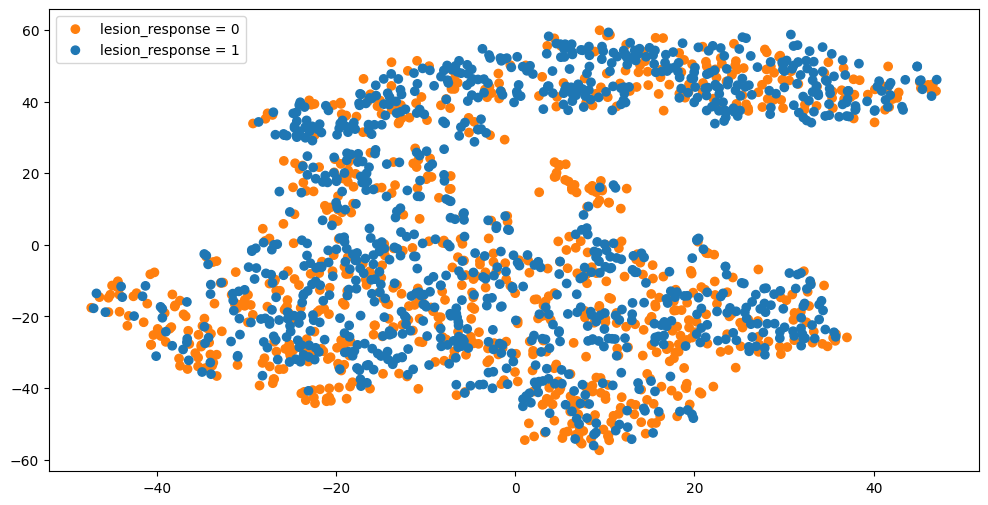

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(df[radiomics.columns])

groupby = 'lesion_response'
colors = {
    0:'tab:orange',
    1:'tab:blue'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


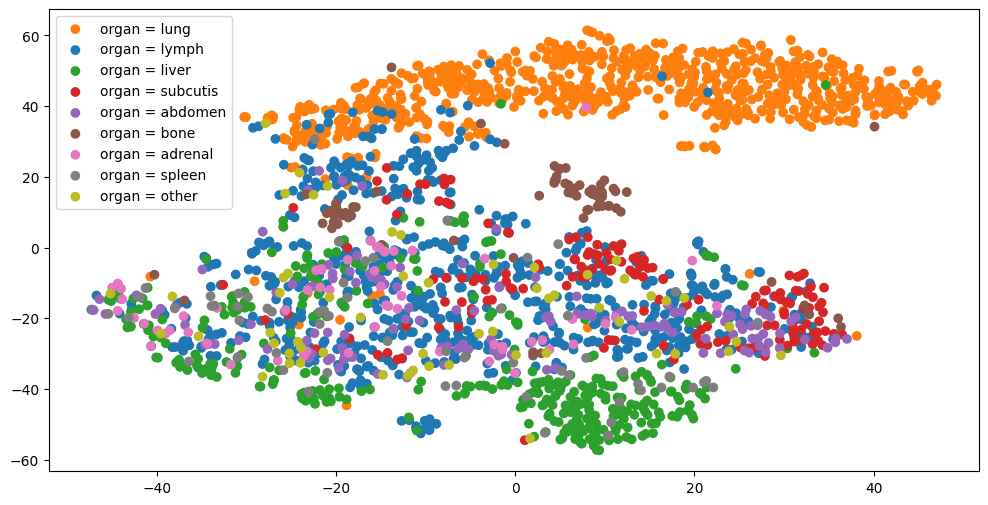

In [29]:
# groupby = 'lesion_response'
# colors = {
#     0:'tab:orange',
#     1:'tab:blue'
# }

groupby = 'organ'
colors = {
    'lung':'tab:orange',
    'lymph':'tab:blue',
    'liver':'tab:green',
    'subcutis':'tab:red',
    'abdomen':'tab:purple',
    'bone':'tab:brown',
    'adrenal':'tab:pink',
    'spleen':'tab:grey',
    'other':'tab:olive'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive


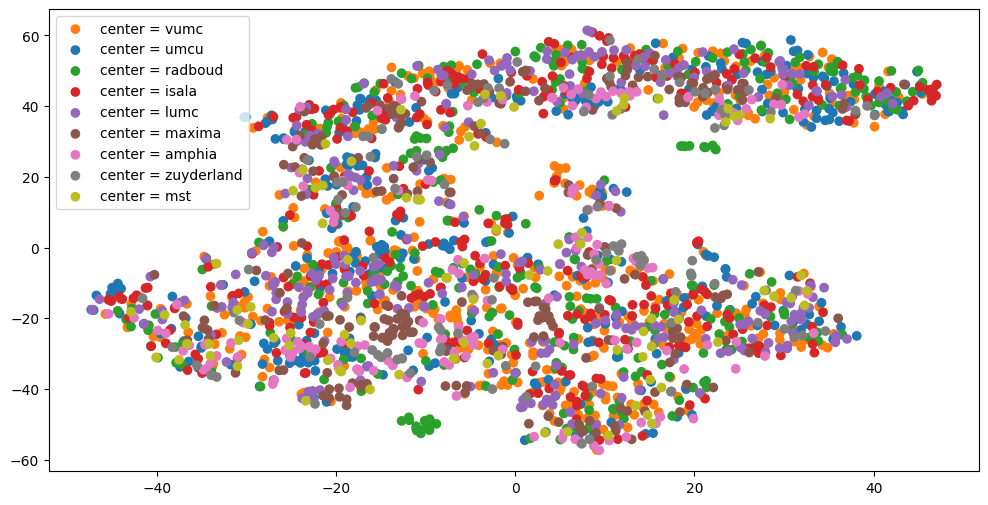

In [30]:
# groupby = 'lesion_response'
# colors = {
#     0:'tab:orange',
#     1:'tab:blue'
# }

groupby = 'center'
colors = {
    'vumc':'tab:orange',
    'umcu':'tab:blue',
    'radboud':'tab:green',
    'isala':'tab:red',
    'lumc':'tab:purple',
    'maxima':'tab:brown',
    'amphia':'tab:pink',
    'zuyderland':'tab:grey',
    'mst':'tab:olive'
}

plt.figure(figsize=(12,6))
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{groupby} = {group}')
plt.legend()
plt.show()

In [18]:
from src.config import dmtr_csv, lesion_level_labels_csv
import pandas as pd

dmtr = pd.read_csv(dmtr_csv).set_index('id')
dmtr = dmtr[dmtr.center != 'umcg']

lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';')
lesion_fu = lesion_fu[lesion_fu.center != 'umcg']

dmtr = dmtr.loc[lesion_fu.patient.unique()]

/tmp/ipykernel_7614/3379226976.py:4: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


In [34]:
stables = dmtr[dmtr['Best overall response'] == 'Stable disease']
delta = pd.to_datetime(stables.last_contact) - pd.to_datetime(stables.start_date)

In [53]:
stables[delta.dt.days < 160].index.tolist()

['IM_161',
 'MAX_109',
 'MAX_326',
 'PREM_AM_008',
 'PREM_AM_055',
 'PREM_IS_001',
 'PREM_MS_094',
 'PREM_UMCU_037',
 'PREM_VU_132']

In [61]:
lesion_fu[lesion_fu.patient == 'PREM_VU_132']

,Unnamed: 0,patient,lesion,name,center,baseline,fu1,fu2,fu3,delta1,delta2,delta3,last_fu,lesion_benefit,lesion_response,liver,lung,organ,fold
1665,1665,PREM_VU_132,PREM_VU_132_0.nii.gz,lymph1,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,lymph,0
1666,1666,PREM_VU_132,PREM_VU_132_1.nii.gz,lymph2,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,lymph,0
1667,1667,PREM_VU_132,PREM_VU_132_2.nii.gz,lung1,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,lung,0
1668,1668,PREM_VU_132,PREM_VU_132_3.nii.gz,lung2,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,lung,0
1669,1669,PREM_VU_132,PREM_VU_132_4.nii.gz,subcutis1,vumc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,subcutis,0


In [111]:
grouped = lesion_fu.groupby('patient').last_fu.apply(list)
at_least_one_lesion = lesion_fu[lesion_fu.patient.isin(grouped[grouped.apply(lambda x: pd.isna(x) == False).apply(any)].index)]
no_lesions = lesion_fu[lesion_fu.patient.isin(grouped[grouped.apply(lambda x: pd.isna(x)).apply(all)].index)].patient.unique()
no_lesions = dmtr.loc[no_lesions]
no_lesions = no_lesions[no_lesions.center != 'radboud']

In [119]:
delta = pd.to_datetime(no_lesions.last_contact) - pd.to_datetime(no_lesions.start_date)
early_death = delta[delta.dt.days < 120].index

In [124]:
other = delta[delta.dt.days >= 120].index

In [134]:
len(lesion_fu[lesion_fu.patient.isin(other)])

44

id
MAX_001          2019-09-19
MAX_307          2019-09-27
PREM_AM_065      2017-02-10
PREM_AM_076      2019-04-24
PREM_IS_011      2018-09-20
PREM_LU_108      2019-02-26
PREM_LU_139      2019-12-30
PREM_LU_145      2018-09-13
PREM_LU_483      2017-03-01
PREM_LU_727      2021-03-12
PREM_MS_172      2020-12-01
PREM_UMCU_017    2019-12-20
PREM_UMCU_030    2020-02-06
Name: start_date, dtype: object

In [121]:
len(lesion_fu[lesion_fu.patient.isin(early_death)]) / 2352

0.07865646258503402

In [122]:
len(lesion_fu[lesion_fu.patient.isin(early_death)])

185

In [94]:
at_least_one_lesion.last_fu.isna().sum() / 2352

0.011479591836734694

In [123]:
at_least_one_lesion.last_fu.isna().sum()

27

In [93]:
(lesion_fu.center == 'radboud').sum() / 2352

0.13903061224489796

In [138]:
grouped = lesion_fu.groupby('patient').last_fu.apply(list)
patients_with_missing = grouped[grouped.apply(pd.isna).apply(any)].index

In [144]:
rest = [pt for pt in patients_with_missing if not pt in other and not pt in early_death and not pt in at_least_one_lesion.patient.unique()]

In [148]:
lesion_fu.patient.isin(other).sum() / len(lesion_fu)

0.01870748299319728

In [149]:
lesion_fu.patient.isin(early_death).sum() / len(lesion_fu)

0.07865646258503402

In [153]:
at_least_one_lesion.last_fu.isna().sum() / len(lesion_fu)

0.011479591836734694

In [174]:
len(lesion_fu[~lesion_fu.last_fu.isna()]) / len(lesion_fu)

0.752125850340136

In [158]:
missing_lesions = lesion_fu[lesion_fu.last_fu.isna()]
print(len(missing_lesions[missing_lesions.center == 'radboud']) / len(lesion_fu))

missing_lesions = missing_lesions[missing_lesions.center != 'radboud']

0.13903061224489796


In [161]:
print(len(missing_lesions[missing_lesions.patient.isin(early_death)]) / len(lesion_fu))

missing_lesions = missing_lesions[~missing_lesions.patient.isin(early_death)]

0.07865646258503402


In [165]:
print(len(missing_lesions[missing_lesions.patient.isin(other)]) / len(lesion_fu))

missing_lesions = missing_lesions[~missing_lesions.patient.isin(other)]

0.01870748299319728


In [170]:
len(missing_lesions[missing_lesions.lesion.isin(at_least_one_lesion.lesion.values)]) / len(lesion_fu)

0.011479591836734694

In [172]:
0.011479591836734694 + 0.01870748299319728 + 0.07865646258503402 + 0.13903061224489796

0.24787414965986396

In [176]:
dmtr[dmtr.center == 'isala']

,upn,idaa,gebjaar,Sex,datovl,registratie_id,registratie_upn,datprim,ptloc,typmel,...,dis_date_icu,discharged_to,landQxpBl19EYZK2h5cD,gevtoxsetall,medtoximipi.1,medtoximiipni.1,pabekendch1,episode_nr,age,response
id,,,,,,,,,,,,,,,,,,,,,
PREM_IS_001,1000419630.0,NaN,1961.0,Female,NaN,NaN,NaN,2017-06-12,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,1.0
PREM_IS_002,1000656330.0,NaN,1977.0,Female,NaN,NaN,NaN,2018-03-12,4.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,1.0
PREM_IS_003,1002780090.0,NaN,1944.0,Male,NaN,NaN,NaN,2020-07-02,5.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,1.0
PREM_IS_004,1003044170.0,NaN,1938.0,Male,2020-05-13,NaN,NaN,2013-07-22,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,0.0
PREM_IS_005,1004082120.0,NaN,1944.0,Female,NaN,NaN,NaN,2020-09-10,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PREM_IS_138,2009337083.0,NaN,1951.0,Male,2019-11-06,NaN,NaN,2016-09-12,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.0
PREM_IS_139,2000094693.0,NaN,1961.0,Male,2017-12-20,NaN,NaN,2013-06-05,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,0.0
PREM_IS_140,2001995960.0,NaN,1941.0,Male,NaN,NaN,NaN,2016-09-20,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,0.0
